# rnn_umesh_palai
RNN using open,high,low, close data from https://github.com/umeshpalai/AlgorithmicTrading-MachineLearning by Umesh Palai.  

The code has been reorganized a little to make it a little easier to read.  The final plot that zooms in on a small subset of the y_predicted vs y_test data shows how RNN's often simply approximate a single period shift of the y_test data.

_I have seen this with other RNN's that attempt to perform regression on securites bar-like time series._

___
## Section 1.0 - imports

In [17]:
#import all libraries
import numpy as np
import pandas as pd
import sklearn.preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf

## Section 1.1 - Define constants

In [18]:
# path to data
dataset_path = './data/RELIANCE.NS.csv'

# Splitting the dataset into Train, Valid & test data 
valid_set_size_percentage = 10 
test_set_size_percentage = 10 
seq_len = 20 # taken sequence length as 20

# parameters & Placeholders 
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 


___
## Section 2.0 - Data scalar method

In [19]:
# data scaling (normalizing)
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df


___
## Section 2.1 - Data loader methods

In [20]:
# load data by batches

def load_data(stock, seq_len):
    data_raw = stock.as_matrix() 
    data = [] 
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]



def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size 
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size     
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]


___
## Section 3.0 - Read dataset, create DataFrame and normalize it

In [21]:
dataset = pd.read_csv(dataset_path, index_col = 0)
df_stock = dataset.copy()
df_stock = df_stock.dropna()
df_stock = df_stock[['Open', 'High', 'Low', 'Close']]

df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

___
## Section 3.1 - Create training, validation and test set data

In [22]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (4497, 19, 4)
y_train.shape =  (4497, 4)
x_valid.shape =  (562, 19, 4)
y_valid.shape =  (562, 4)
x_test.shape =  (562, 19, 4)
y_test.shape =  (562, 4)


___
## Section 3.2 - Create tensorflow model

In [23]:
"""Building the Model"""

train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# function to get the next batch
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)



#RNN 
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
# LSTM  
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#        for layer in range(n_layers)]

#LSTM with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

#GRU 
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)] 

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.c(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence

# Cost function
loss = tf.reduce_mean(tf.square(outputs - y))

#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)


___
## Section 4.0 - Train the model

In [28]:
# Fitting the model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
    # Predictions
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

0.00 epochs: MSE train/valid = 0.131812/0.323485
4.99 epochs: MSE train/valid = 0.000071/0.000063
9.98 epochs: MSE train/valid = 0.000085/0.000117
14.98 epochs: MSE train/valid = 0.000052/0.000047
19.97 epochs: MSE train/valid = 0.000061/0.000068
24.96 epochs: MSE train/valid = 0.000045/0.000030
29.95 epochs: MSE train/valid = 0.000044/0.000033
34.95 epochs: MSE train/valid = 0.000062/0.000080
39.94 epochs: MSE train/valid = 0.000043/0.000033
44.93 epochs: MSE train/valid = 0.000048/0.000047
49.92 epochs: MSE train/valid = 0.000042/0.000031
54.91 epochs: MSE train/valid = 0.000043/0.000034
59.91 epochs: MSE train/valid = 0.000118/0.000225
64.90 epochs: MSE train/valid = 0.000042/0.000035
69.89 epochs: MSE train/valid = 0.000099/0.000158
74.88 epochs: MSE train/valid = 0.000093/0.000161
79.88 epochs: MSE train/valid = 0.000041/0.000030
84.87 epochs: MSE train/valid = 0.000049/0.000048
89.86 epochs: MSE train/valid = 0.000096/0.000171
94.85 epochs: MSE train/valid = 0.000054/0.000055
99.

___
## Section 4.1 - Create and graph predictions

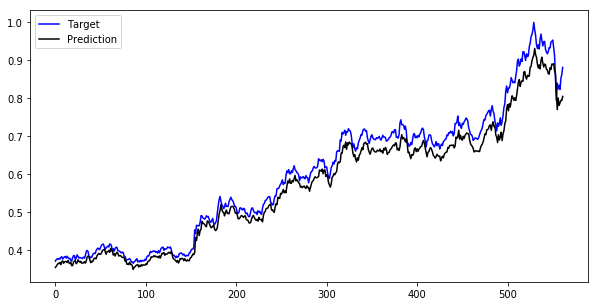

In [29]:

#checking prediction output nos 
y_test_pred.shape

# ploting the graph
comp = pd.DataFrame({'Column1':y_test[:,3],'Column2':y_test_pred[:,3]})
plt.figure(figsize=(10,5))
plt.plot(comp['Column1'], color='blue', label='Target')
plt.plot(comp['Column2'], color='black', label='Prediction')
plt.legend()
plt.show()

___
## Section 4.2 - zoom in on data
The plot below shows that the predictions seem to actually be very close to a single period shift of y_test.

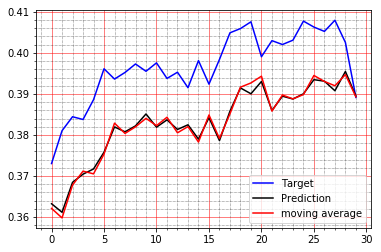

In [88]:
b=100
q = 30
yt = y_test[b:(b+q),3]
ytp = y_test_pred[b:(b+q),3]
x_shift = 1
y_ma  = y_test[(b-offset):(b+q-offset),3] 
y_ma_offset = (ytp - y_ma).mean()
y_ma = y_ma - - y_ma_offset
fig, ax = plt.subplots() 
plt.plot(yt, color='blue', label='Target')
plt.plot(ytp, color='black', label='Prediction')
plt.plot(y_ma, color='red', label='moving average')
plt.legend()
ax.minorticks_on()

# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth=0.5, color='black')
# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth=0.5, color='red')
plt.show()


## End